In [1]:
import yt 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import os
import functions

In [6]:
data_dir = r'0.1_1e6_2'
snapshot = r'plt02048'
test_fields = ['RHOB', 'WVX', 'WVY', 'WVZ', 'EPS']

ds, cube = functions.load_snapshot(data_dir+'/' + snapshot, test_fields)

yt : [INFO     ] 2024-07-01 12:50:12,668 Parameters: current_time              = 2.0
yt : [INFO     ] 2024-07-01 12:50:12,669 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2024-07-01 12:50:12,670 Parameters: domain_left_edge          = [-1. -1.  0.]
yt : [INFO     ] 2024-07-01 12:50:12,670 Parameters: domain_right_edge         = [1. 1. 1.]


In [3]:
rho = cube["RHOB"].d
eps = cube["EPS"].d
temp = eps/rho
lorentz = functions.lorentz(cube)
k, E_spectrum = functions.make_ke_ps(ds, cube)


In [4]:
index = np.argmax(E_spectrum)
kmax = k[index]
Emax = E_spectrum[index]

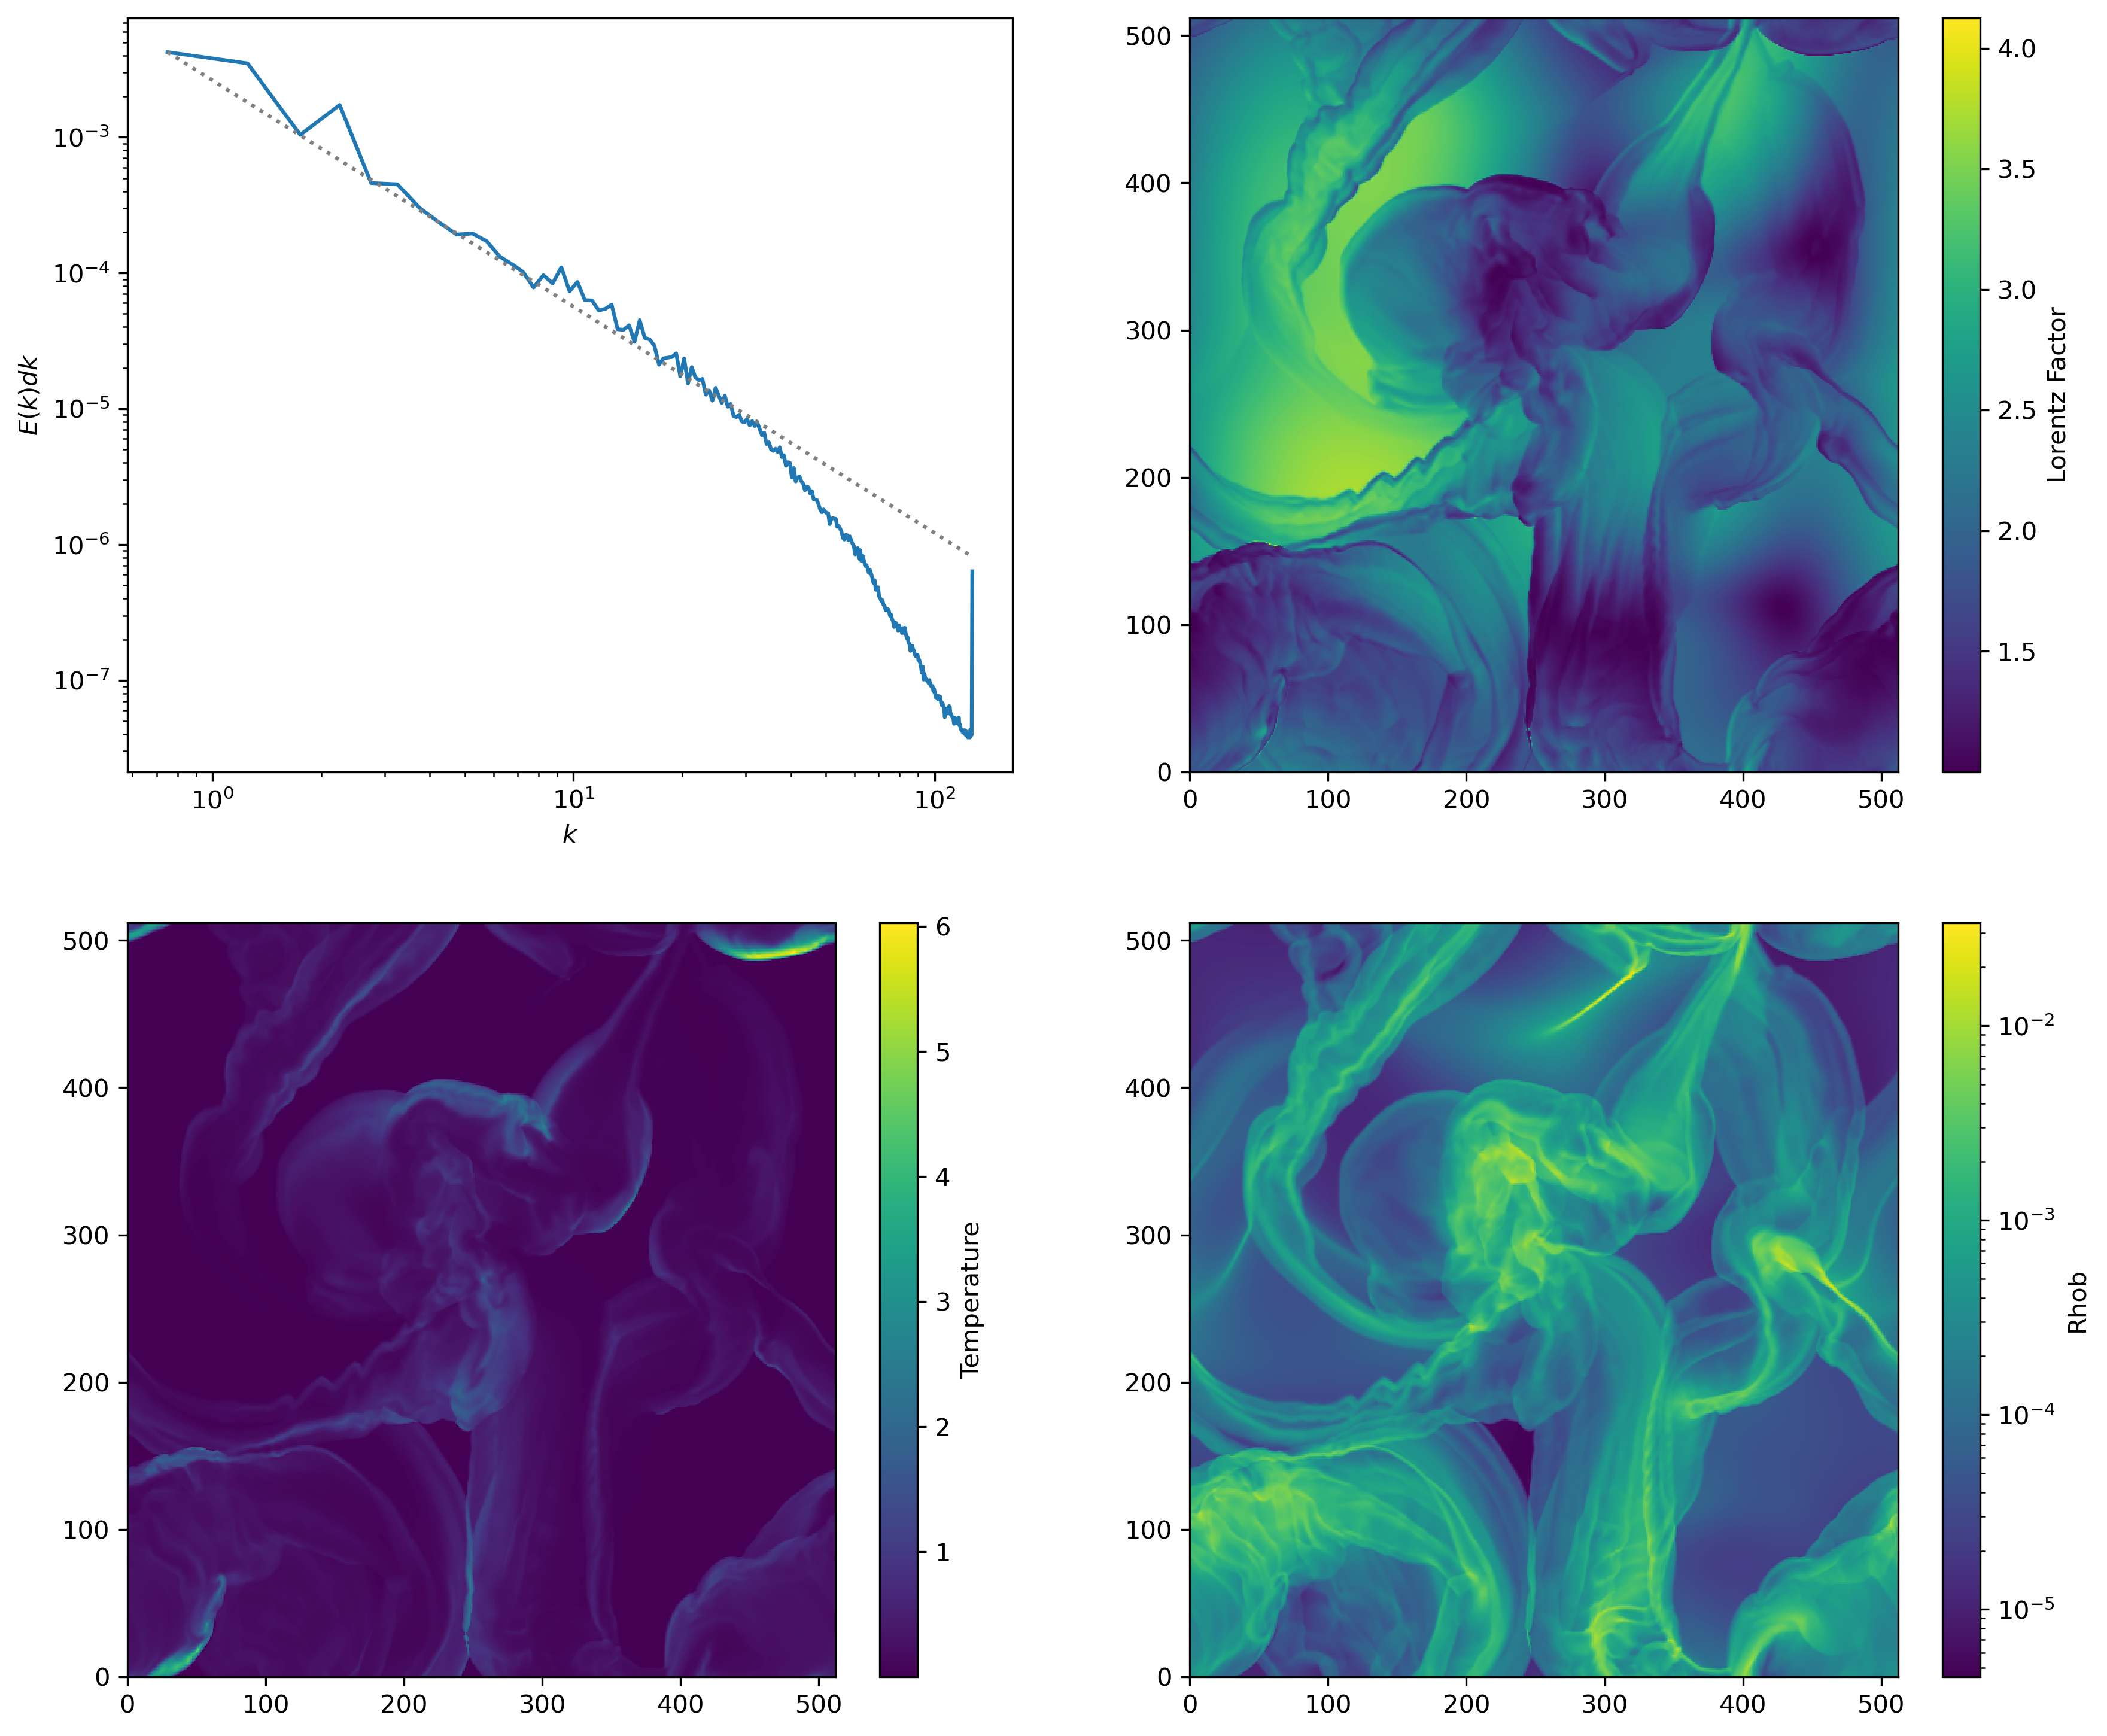

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(14,12), dpi=300) 

ax[0, 0].loglog(k, E_spectrum)
ax[0, 0].loglog(k, Emax*(k/kmax)**(-5/3), ls=':', color="0.5")
ax[0, 0].set_xlabel(r"$k$") 
ax[0, 0].set_ylabel(r"$E(k)dk$")

im1 = ax[0, 1].pcolormesh(lorentz[:,:,0])
fig.colorbar(im1, ax=ax[0,1], label=r'Lorentz Factor')

im2 = ax[1, 0].pcolormesh(temp[:,:,0])
fig.colorbar(im2, ax=ax[1,0], label=r'Temperature')

im3 = ax[1, 1].pcolormesh(rho[:, :, 0], norm=colors.LogNorm())
fig.colorbar(im3, ax=ax[1,1], label=r'Rhob')

#plt.show()
os.makedirs(f'figures/{data_dir}', exist_ok=True)
plt.savefig(f'figures/{data_dir}/{snapshot}.png', dpi=300)